# **Capstone Project Draft - M6 | Group #5483**

---
### **A Comprehensive Evaluation of Avellaneda & Stoikov's Approach in Cryptocurrency Markets**
#### Track : Cryptocurrency Markets (Microstructure)
#### Topic : Avellaneda & Stoikov’s Market-making Strategy
Khaled TAMIM - WorldQuant University - ktamim.pro@gmail.com


---



##1. Avellaneda & Stoikov's Market-Making Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Set random seed for reproducibility
np.random.seed(123)

# Function to calculate average symmetric spread and probability
def calculate_symmetric_spread(T, dt, gamma, sigma, k, A):
    symmetric_spread = 0
    # Loop over time steps
    for i in np.arange(0, T, dt):
        # Calculate symmetric spread
        symmetric_spread += gamma * sigma**2 * (T - i) + (2/gamma) * np.log(1 + (gamma / k))
    # Calculate average symmetric spread
    average_symmetric_spread = (symmetric_spread / (T / dt))
    # Calculate probability
    probability = A * np.exp(- k * average_symmetric_spread / 2) * dt
    return average_symmetric_spread, probability

# Function to simulate trading strategies
def simulate_trading(s0, T, dt, sigma, gamma, k, A, sim_length):
    # Initialize lists to store inventory and P&L for each strategy
    inventory_strategy1 = [0] * sim_length
    pnl_strategy1 = [0] * sim_length
    inventory_strategy2 = [0] * sim_length
    pnl_strategy2 = [0] * sim_length
    # Initialize price lists
    price_a = [0] * (int(T / dt) + 1)
    price_b = [0] * (int(T / dt) + 1)
    mid_price = [0] * (int(T / dt) + 1)
    # Calculate average symmetric spread and probability
    average_symmetric_spread, probability = calculate_symmetric_spread(T, dt, gamma, sigma, k, A)
    # Simulation loop
    for i in range(sim_length):
        # Generate white noise
        white_noise = sigma * np.sqrt(dt) * np.random.choice([1, -1], int(T / dt))
        price_process = s0 + np.cumsum(white_noise)
        price_process = np.insert(price_process, 0, s0)
        # Loop over time steps
        for step, s in enumerate(price_process):
            # Calculate reservation price and spread
            reservation_price = s - inventory_strategy1[i] * gamma * sigma**2 * (T - step * dt)
            spread = gamma * sigma**2 * (T - step * dt) + (2 / gamma) * np.log(1 + (gamma / k))
            spread /= 2
            # Determine ask and bid spreads
            if reservation_price >= s:
                ask_spread = spread + (reservation_price - s)
                bid_spread = spread - (reservation_price - s)
            else:
                ask_spread = spread - (s - reservation_price)
                bid_spread = spread + (s - reservation_price)
            # Calculate ask and bid probabilities
            ask_probability = A * np.exp(- k * ask_spread) * dt
            bid_probability = A * np.exp(- k * bid_spread) * dt
            ask_probability = max(0, min(ask_probability, 1))
            bid_probability = max(0, min(bid_probability, 1))
            # Decide ask and bid actions for strategy 1
            ask_action_s1 = np.random.choice([1, 0], p=[ask_probability, 1 - ask_probability])
            bid_action_s1 = np.random.choice([1, 0], p=[bid_probability, 1 - bid_probability])
            # Update inventory and P&L for strategy 1
            inventory_strategy1[i] -= ask_action_s1
            pnl_strategy1[i] += ask_action_s1 * (s + ask_spread)
            inventory_strategy1[i] += bid_action_s1
            pnl_strategy1[i] -= bid_action_s1 * (s - bid_spread)
            # Store prices for the first simulation
            if i == 0:
                price_a[step] = s + ask_spread
                price_b[step] = s - bid_spread
                mid_price[step] = s
            # Decide ask and bid actions for strategy 2
            ask_action_s2 = np.random.choice([1, 0], p=[probability, 1 - probability])
            bid_action_s2 = np.random.choice([1, 0], p=[probability, 1 - probability])
            # Update inventory and P&L for strategy 2
            inventory_strategy2[i] -= ask_action_s2
            pnl_strategy2[i] += ask_action_s2 * (s + average_symmetric_spread / 2)
            inventory_strategy2[i] += bid_action_s2
            pnl_strategy2[i] -= bid_action_s2 * (s - average_symmetric_spread / 2)
        # Final P&L calculation
        pnl_strategy1[i] += inventory_strategy1[i] * s
        pnl_strategy2[i] += inventory_strategy2[i] * s
    return pnl_strategy1, pnl_strategy2, price_a, price_b, mid_price

# Function to plot P&L histogram
def plot_profit_loss_histogram(pnl_strategy1, pnl_strategy2, x_range, y_range):
    bins = np.arange(x_range[0], x_range[1] + 1, 4)
    plt.hist(pnl_strategy1, bins=bins, alpha=0.25, label="Inventory Strategy")
    plt.hist(pnl_strategy2, bins=bins, alpha=0.25, label="Symmetric Strategy")
    plt.xlabel('Profit/Loss')
    plt.ylabel('Frequency')
    plt.legend()
    plt.axis(x_range + y_range)
    plt.title("P&L Histogram")
    plt.show()

# Function to plot cumulative P&L
def plot_cumulative_profit_loss(pnl_strategy1, pnl_strategy2):
    cumulative_pnl_strategy1 = np.cumsum(pnl_strategy1)
    cumulative_pnl_strategy2 = np.cumsum(pnl_strategy2)
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_pnl_strategy1, label='Cumulative P&L - Inventory Strategy')
    plt.plot(cumulative_pnl_strategy2, label='Cumulative P&L - Symmetric Strategy')
    plt.xlabel('Time')
    plt.ylabel('Cumulative P&L')
    plt.title('Cumulative P&L of the Two Strategies')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot prices
def plot_prices(x, price_a, price_b, mid_price):
    plt.plot(x, price_a, linewidth=1.0, linestyle="-", label="ASK")
    plt.plot(x, price_b, linewidth=1.0, linestyle="-", label="BID")
    plt.plot(x, mid_price, linewidth=1.0, linestyle="-", label="MID-PRICE")
    plt.legend()
    plt.title("The Mid-Price and the Optimal Bid and Ask Quotes")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.show()

# Function to print statistics
def print_statistics(pnl_strategy1, pnl_strategy2, inventory_strategy1, inventory_strategy2):
    table = PrettyTable()
    table.title = "Trading Strategy Performance"
    table.field_names = ["Statistic", "Inventory Strategy", "Symmetric Strategy"]
    table.add_row(["Mean P&L", "{:.2f}".format(np.array(pnl_strategy1).mean()), "{:.2f}".format(np.array(pnl_strategy2).mean())])
    table.add_row(["Std Deviation of P&L", "{:.2f}".format(np.sqrt(np.array(pnl_strategy1).var())), "{:.2f}".format(np.sqrt(np.array(pnl_strategy2).var()))])
    print(table)

###Simulation 0 - AS Model "By the book"

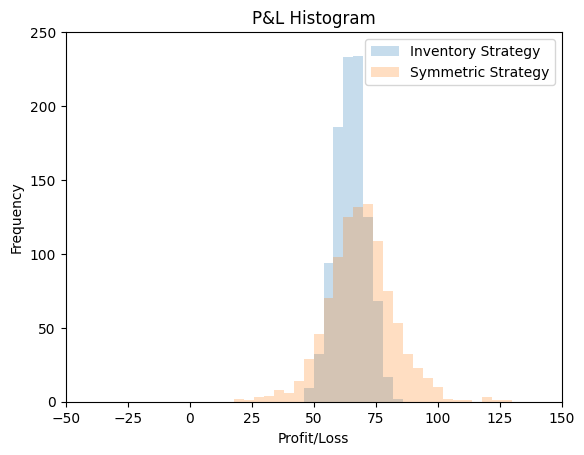

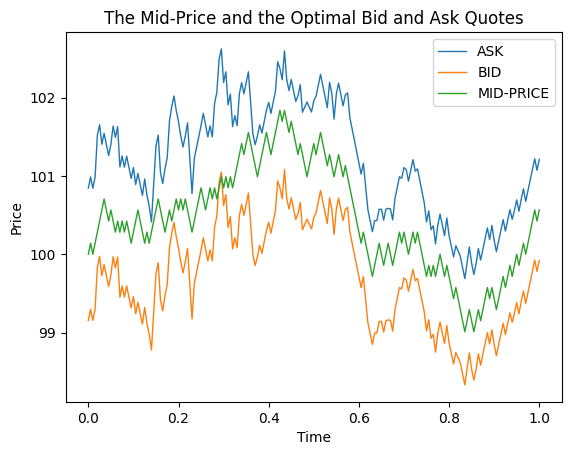

+----------------------------------------------------------------+
|                  Trading Strategy Performance                  |
+----------------------+--------------------+--------------------+
|      Statistic       | Inventory Strategy | Symmetric Strategy |
+----------------------+--------------------+--------------------+
|       Mean P&L       |       65.03        |       68.98        |
| Std Deviation of P&L |        6.30        |       13.74        |
+----------------------+--------------------+--------------------+


In [ ]:
# Parameters
s0 = 100
T = 1
sigma = 2
dt = 0.005
q0 = 0
gamma = 0.1
k = 1.5
A = 140
sim_length = 1000

# Simulate trading
pnl_s1, pnl_s2, price_a, price_b, midprice = simulate_trading(s0, T, dt, sigma, gamma, k, A, sim_length)

# Plot histograms
x_range = [-50, 150]
y_range = [0, 250]
plot_profit_loss_histogram(pnl_s1, pnl_s2, x_range, y_range)

# Plot prices
x = np.arange(0, T + dt, dt)
plot_prices(x, price_a, price_b, midprice)

# Print statistics
print_statistics(pnl_s1, pnl_s2, [q0] * sim_length, [q0] * sim_length)

###Simulation 1 - Low Risk Aversion gamma = 0.01 to 0.5 & Low Volatility sigma = 0.5 to 8

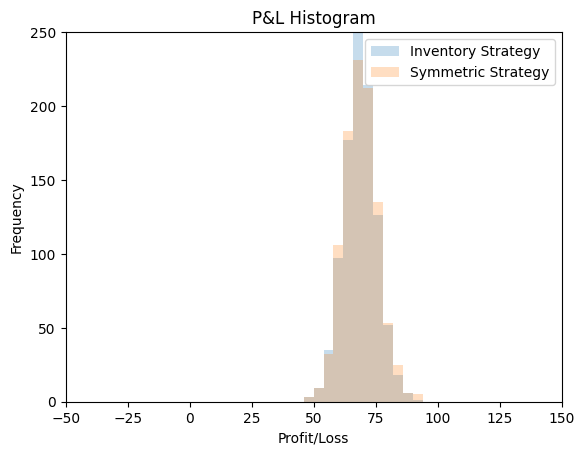

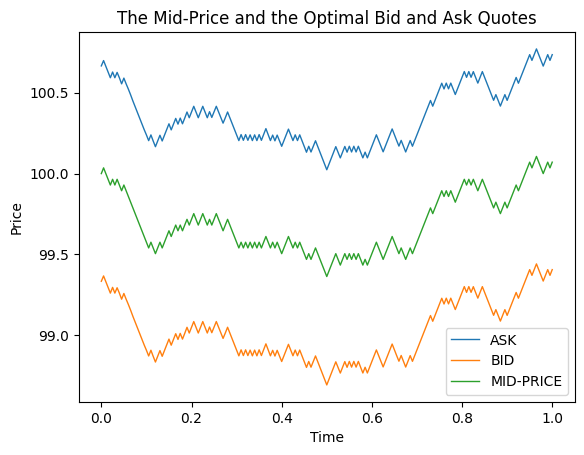

+----------------------------------------------------------------+
|                  Trading Strategy Performance                  |
+----------------------+--------------------+--------------------+
|      Statistic       | Inventory Strategy | Symmetric Strategy |
+----------------------+--------------------+--------------------+
|       Mean P&L       |       68.84        |       69.00        |
| Std Deviation of P&L |        6.48        |        6.87        |
+----------------------+--------------------+--------------------+


In [ ]:
# Parameters
gamma = 0.01
sigma = 0.5

# Simulate trading
pnl_s1, pnl_s2, price_a, price_b, midprice = simulate_trading(s0, T, dt, sigma, gamma, k, A, sim_length)

# Plot histograms
plot_profit_loss_histogram(pnl_s1, pnl_s2, x_range, y_range)

# Plot prices
plot_prices(x, price_a, price_b, midprice)

# Print statistics
print_statistics(pnl_s1, pnl_s2, [q0] * sim_length, [q0] * sim_length)

###Simulation 2 - High Risk Aversion gamma = 0.5 & Low Volatility sigma = 0.5

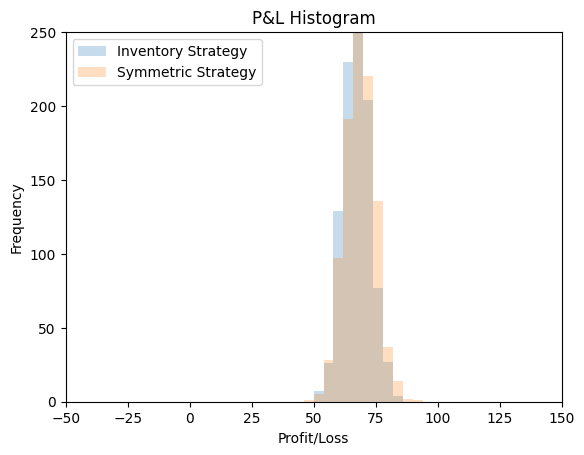

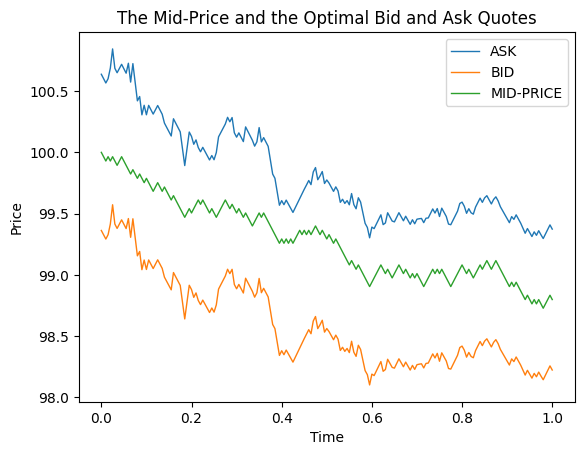

+----------------------------------------------------------------+
|                  Trading Strategy Performance                  |
+----------------------+--------------------+--------------------+
|      Statistic       | Inventory Strategy | Symmetric Strategy |
+----------------------+--------------------+--------------------+
|       Mean P&L       |       67.44        |       68.68        |
| Std Deviation of P&L |        5.39        |        5.93        |
+----------------------+--------------------+--------------------+


In [ ]:
# Parameters
gamma = 0.5
sigma = 0.5

# Simulate trading
pnl_s1, pnl_s2, price_a, price_b, midprice = simulate_trading(s0, T, dt, sigma, gamma, k, A, sim_length)

# Plot histograms
plot_profit_loss_histogram(pnl_s1, pnl_s2, x_range, y_range)

# Plot prices
plot_prices(x, price_a, price_b, midprice)

# Print statistics
print_statistics(pnl_s1, pnl_s2, [q0] * sim_length, [q0] * sim_length)

###Simulation 3 - High Risk Aversion gamma = 0.5 & High Volatility sigma = 8

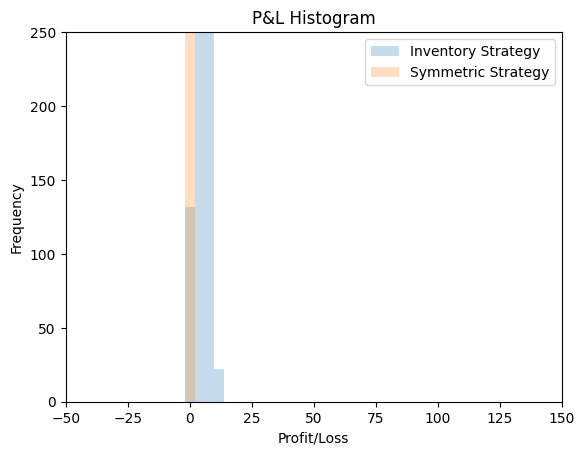

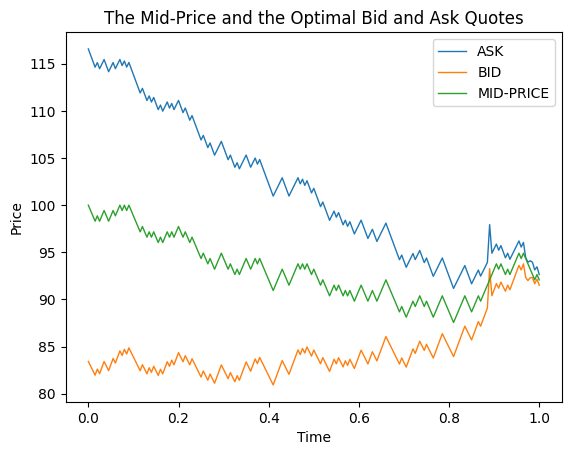

+----------------------------------------------------------------+
|                  Trading Strategy Performance                  |
+----------------------+--------------------+--------------------+
|      Statistic       | Inventory Strategy | Symmetric Strategy |
+----------------------+--------------------+--------------------+
|       Mean P&L       |        4.75        |        0.00        |
| Std Deviation of P&L |        2.35        |        0.00        |
+----------------------+--------------------+--------------------+


In [ ]:
# Parameters
gamma = 0.5
sigma = 8

# Simulate trading
pnl_s1, pnl_s2, price_a, price_b, midprice = simulate_trading(s0, T, dt, sigma, gamma, k, A, sim_length)

# Plot histograms
plot_profit_loss_histogram(pnl_s1, pnl_s2, x_range, y_range)

# Plot prices
plot_prices(x, price_a, price_b, midprice)

# Print statistics
print_statistics(pnl_s1, pnl_s2, [q0] * sim_length, [q0] * sim_length)

###Simulation 4 - Low Risk Aversion gamma = 0.01 & High Volatility sigma = 8

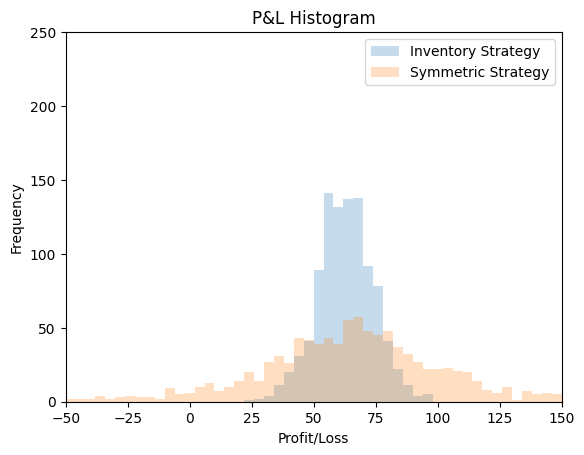

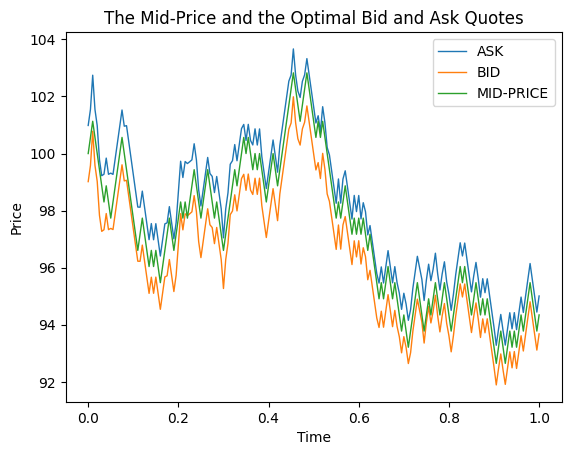

+----------------------------------------------------------------+
|                  Trading Strategy Performance                  |
+----------------------+--------------------+--------------------+
|      Statistic       | Inventory Strategy | Symmetric Strategy |
+----------------------+--------------------+--------------------+
|       Mean P&L       |       62.80        |       64.70        |
| Std Deviation of P&L |       11.19        |       46.27        |
+----------------------+--------------------+--------------------+


In [ ]:
# Parameters
gamma = 0.01
sigma = 8

# Simulate trading
pnl_s1, pnl_s2, price_a, price_b, midprice = simulate_trading(s0, T, dt, sigma, gamma, k, A, sim_length)

# Plot histograms
plot_profit_loss_histogram(pnl_s1, pnl_s2, x_range, y_range)

# Plot prices
plot_prices(x, price_a, price_b, midprice)

# Print statistics
print_statistics(pnl_s1, pnl_s2, [q0] * sim_length, [q0] * sim_length)

##2. Application of the AS Model to Real world Data

### 2.1 Coinbase Cryptocurrency Exchange

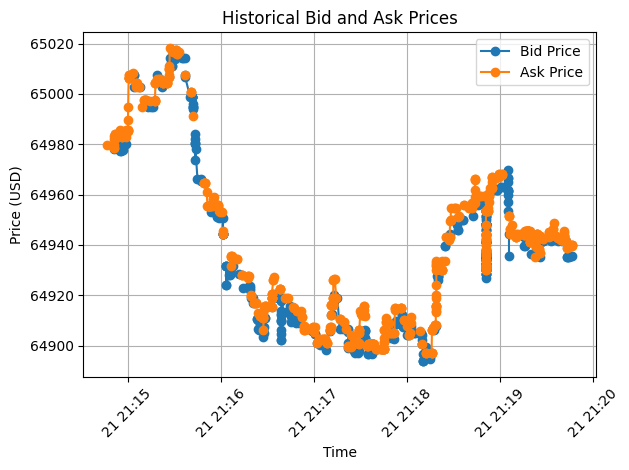

In [ ]:
import requests
from datetime import datetime
import matplotlib.pyplot as plt

def get_historical_trades(symbol, start_date, end_date):
    url = f'https://api.pro.coinbase.com/products/{symbol}/trades'
    params = {
        'start': start_date.isoformat(),
        'end': end_date.isoformat()
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print('Failed to fetch historical trade data from Coinbase Pro API.')
        return None

def extract_bid_ask(trades):
    bid_prices = []
    ask_prices = []
    timestamps = []
    for trade in trades:
        if trade['side'] == 'buy':
            bid_prices.append(float(trade['price']))
            ask_prices.append(None)  # Placeholder for ask price if not available
        elif trade['side'] == 'sell':
            ask_prices.append(float(trade['price']))
            bid_prices.append(None)  # Placeholder for bid price if not available
        # Parse the timestamp directly
        timestamp_str = trade['time'][:-1]  # Remove the last character ('Z')
        timestamps.append(datetime.fromisoformat(timestamp_str))

    return bid_prices, ask_prices, timestamps


def plot_bid_ask(bid_prices, ask_prices, timestamps):
     #plt.figure(figsize=(10, 6))
     plt.plot(timestamps, bid_prices, label='Bid Price', marker='o', linestyle='-')
     plt.plot(timestamps, ask_prices, label='Ask Price', marker='o', linestyle='-')

     plt.title('Historical Bid and Ask Prices')
     plt.xlabel('Time')
     plt.ylabel('Price (USD)')
     plt.xticks(rotation=45)
     plt.legend()
     plt.grid(True)
     plt.tight_layout()
     plt.show()

symbol = 'BTC-USD'
start_date = datetime(2024, 4, 8, 6, 0, 0)
end_date = datetime.now()

historical_trades = get_historical_trades(symbol, start_date, end_date)
if historical_trades:
    bid_prices = []
    ask_prices = []
    timestamps = []
    for trade in historical_trades:
        trade_bid_prices, trade_ask_prices, trade_timestamps = extract_bid_ask([trade])
        if trade_bid_prices:
            bid_prices.extend(trade_bid_prices)
            ask_prices.extend(trade_ask_prices)
            timestamps.extend(trade_timestamps)
    plot_bid_ask(bid_prices, ask_prices, timestamps)

### 2.2 Application of the AS Model to Real world Data (Binance API)


In [ ]:
pip install ccxt

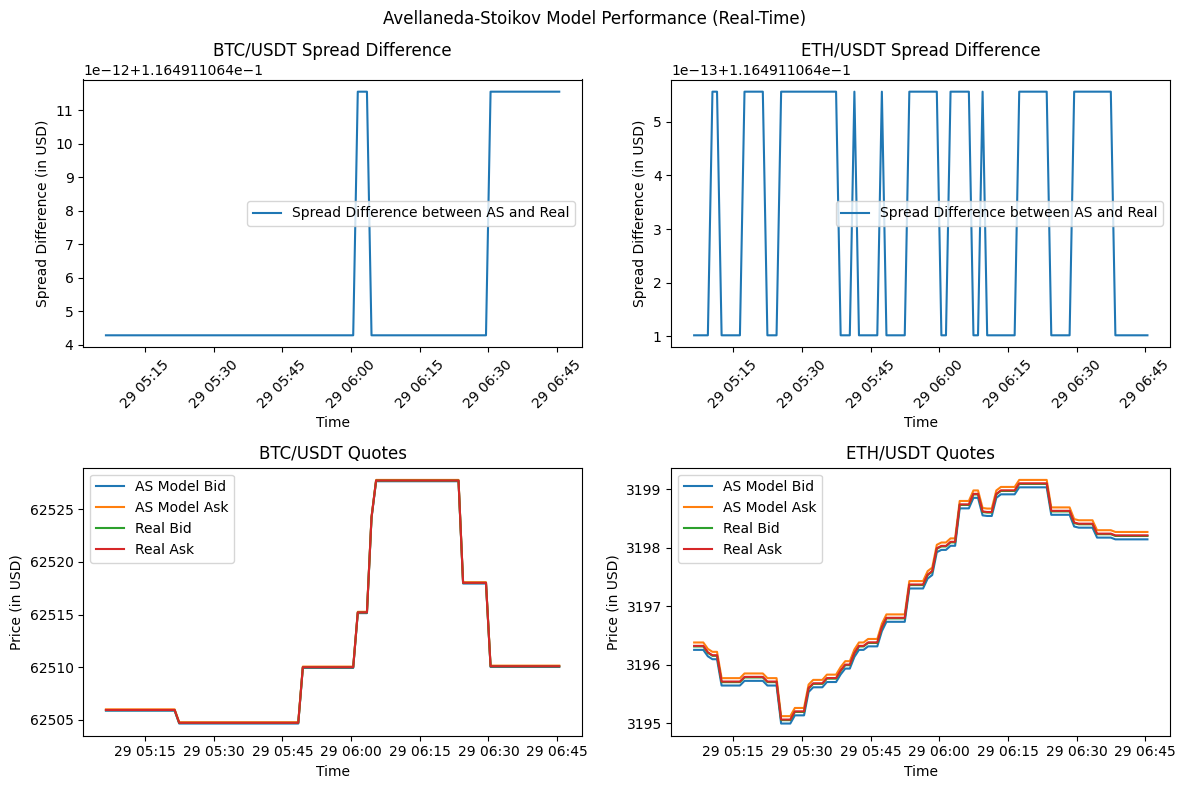

In [ ]:
import numpy as np
import pandas as pd
import ccxt  # For real-time exchange data
import matplotlib.pyplot as plt
from scipy.stats import norm

# Exchange and symbols (replace with your choice)
exchange = ccxt.binance()
symbols = ["BTC/USDT", "ETH/USDT"]

# Define your proxy settings
proxy_host = '91.245.88.174'
proxy_port = '50100'
username = 'ktamimpro'
password = 'bUv2nWZsDt'

# Define the proxy URL with authentication
proxy_url = f"http://{username}:{password}@{proxy_host}:{proxy_port}/"

# Initialize the Binance exchange
exchange = ccxt.binance({
    'apiKey': 'k5TQskeKbtfvD8cf03x7YTLV4aIZoGP5i4CNTSZu1v32N9LhwNcTooxA6P5gNlFi',
    'secret': '4UmZl190bWQHBv3ytPTRewg1Qfl7ce3RiokCCmwpm1aqHqg9TBqBjzQLBN0aXgz6',
})

exchange.httpsProxy = proxy_url

# Avellaneda-Stoikov model implementation
def avellaneda_stoikov_quotes(mid_price, inventory, model_params):
    gamma, sigma, T, k, M = model_params
    bid_quote = mid_price - inventory * k - np.sqrt(gamma * sigma**2 * T)
    ask_quote = mid_price + inventory * k + np.sqrt(gamma * sigma**2 * T)
    return bid_quote, ask_quote

# Performance evaluation loop with real-time data
model_params = (0.1, 0.2, 1, 1.5, 0.5)  # Adapted parameters for cryptocurrency market
evaluation_period = 100  # Number of data points for comparison
inventory = {symbol: 0 for symbol in symbols}  # Initial inventory per symbol
prices = {symbol: [] for symbol in symbols}  # Track execution prices (replace with actual execution logic)
pnl = {symbol: 0 for symbol in symbols}  # Track PnL (replace with actual calculation)
cumulative_pnl = {symbol: [] for symbol in symbols}  # Track cumulative PnL

spread_differences = {symbol: [] for symbol in symbols}
model_bids = {symbol: [] for symbol in symbols}
model_asks = {symbol: [] for symbol in symbols}
real_bids = {symbol: [] for symbol in symbols}
real_asks = {symbol: [] for symbol in symbols}

for i in range(evaluation_period):
    for symbol in symbols:
        # Fetch current order book for the symbol
        orderbook = exchange.fetch_order_book(symbol)

        # Calculate mid-price from best bid and ask
        mid_price = (orderbook['bids'][0][0] + orderbook['asks'][0][0]) / 2

        model_bid, model_ask = avellaneda_stoikov_quotes(mid_price, inventory[symbol], model_params)

        execution_price = mid_price

        spread_difference = (model_ask - model_bid) - (orderbook['asks'][0][0] - orderbook['bids'][0][0])
        spread_differences[symbol].append(spread_difference)

        model_bids[symbol].append(model_bid)
        model_asks[symbol].append(model_ask)
        real_bids[symbol].append(orderbook['bids'][0][0])
        real_asks[symbol].append(orderbook['asks'][0][0])

        # Update inventory and PnL (replace with actual calculations)
        inventory_update = 0  # Simulate trading logic here (account for quantity changes)
        inventory[symbol] += inventory_update

        # Placeholder PnL calculation (replace with actual logic based on execution price and fees)
        if inventory_update > 0:  # Buying
            pnl[symbol] -= (execution_price + exchange.fetch_ticker(symbol)['ask']) * inventory_update
        elif inventory_update < 0:  # Selling
            pnl[symbol] += (execution_price - exchange.fetch_ticker(symbol)['bid']) * abs(inventory_update)

        prices[symbol].append(execution_price)  # Track execution prices

        # Update cumulative PnL
        cumulative_pnl[symbol].append(pnl[symbol])

# Convert data point index to time units
time_units = pd.date_range(start=pd.Timestamp.now(), periods=evaluation_period, freq='1min')

# Generate multiple plots and table for evaluation
fig, axes = plt.subplots(2, len(symbols), figsize=(12, 8))
fig.suptitle('Avellaneda-Stoikov Model Performance (Real-Time)')

for i, symbol in enumerate(symbols):
    axes[0, i].plot(time_units, spread_differences[symbol], label='Spread Difference between AS and Real')
    axes[0, i].set_title(f"{symbol} Spread Difference")
    axes[0, i].legend()
    axes[0, i].set_xlabel('Time')  # Add x-axis title
    axes[0, i].set_ylabel('Spread Difference (in USD)')  # Add y-axis title

    axes[1, i].plot(time_units, model_bids[symbol], label='AS Model Bid')
    axes[1, i].plot(time_units, model_asks[symbol], label='AS Model Ask')
    axes[1, i].plot(time_units, real_bids[symbol], label='Real Bid')
    axes[1, i].plot(time_units, real_asks[symbol], label='Real Ask')
    axes[1, i].set_title(f"{symbol} Quotes")
    axes[1, i].legend()
    axes[1, i].set_xlabel('Time')  # Add x-axis title
    axes[1, i].set_ylabel('Price (in USD)')  # Add y-axis title

    axes[0, i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


### 2.3 Refinement and Optimization of the AS Model with Real Data (Binance API)


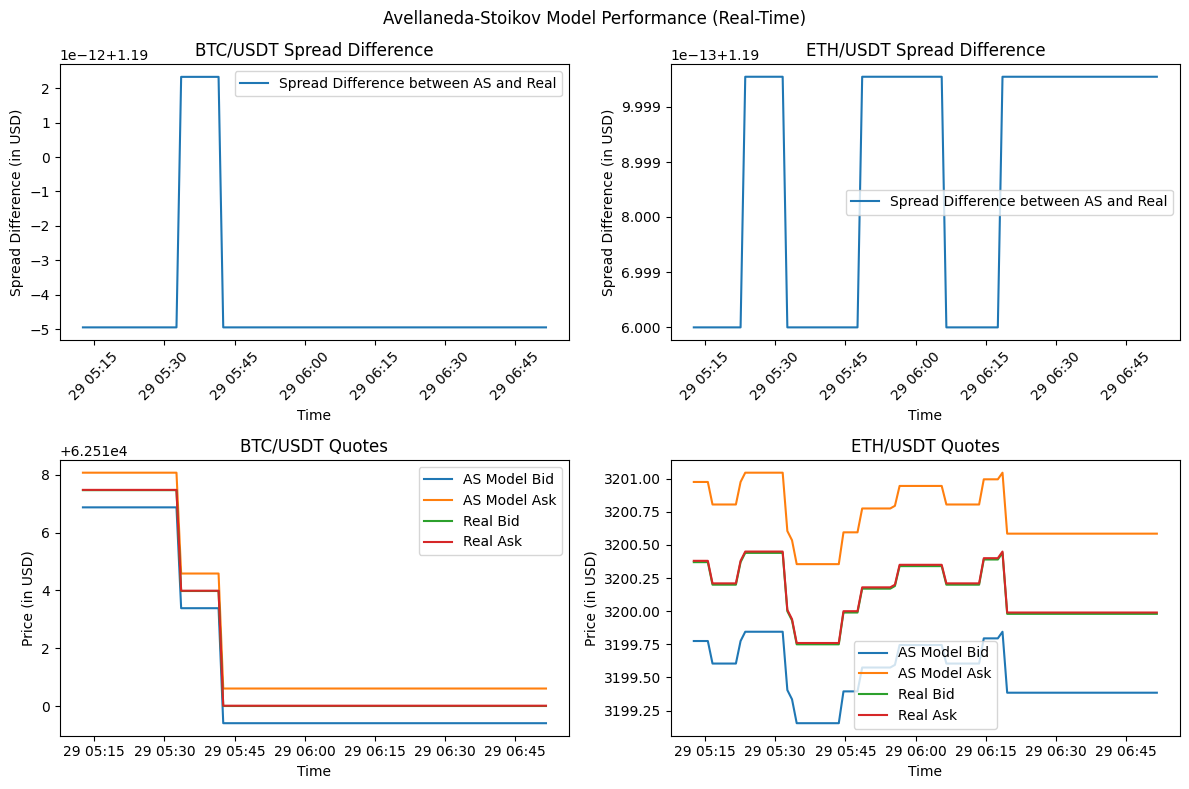

In [ ]:
import numpy as np
import pandas as pd
import ccxt  # For real-time exchange data
import matplotlib.pyplot as plt
from scipy.stats import norm

# Exchange and symbols (replace with your choice)
exchange = ccxt.binance()
symbols = ["BTC/USDT", "ETH/USDT"]

# Define your proxy settings
proxy_host = '91.245.88.174'
proxy_port = '50100'
username = 'ktamimpro'
password = 'bUv2nWZsDt'

# Define the proxy URL with authentication
proxy_url = f"http://{username}:{password}@{proxy_host}:{proxy_port}/"

# Initialize the Binance exchange
exchange = ccxt.binance({
    'apiKey': 'k5TQskeKbtfvD8cf03x7YTLV4aIZoGP5i4CNTSZu1v32N9LhwNcTooxA6P5gNlFi',
    'secret': '4UmZl190bWQHBv3ytPTRewg1Qfl7ce3RiokCCmwpm1aqHqg9TBqBjzQLBN0aXgz6',
})

exchange.httpsProxy = proxy_url

# Avellaneda-Stoikov model implementation
def avellaneda_stoikov_quotes(mid_price, inventory, model_params):
    gamma, sigma, T, k, M = model_params
    bid_quote = mid_price - inventory * k - np.sqrt(gamma * sigma**2 * T)
    ask_quote = mid_price + inventory * k + np.sqrt(gamma * sigma**2 * T)
    return bid_quote, ask_quote

# Performance evaluation loop with real-time data
model_params = (0.01, 6, 1, 2, 0.5)  # Adapted parameters for BTCUSD and ETHUSD cryptocurrency market

evaluation_period = 100  # Number of data points for comparison
inventory = {symbol: 0 for symbol in symbols}  # Initial inventory per symbol
prices = {symbol: [] for symbol in symbols}  # Track execution prices (replace with actual execution logic)
pnl = {symbol: 0 for symbol in symbols}  # Track PnL (replace with actual calculation)
cumulative_pnl = {symbol: [] for symbol in symbols}  # Track cumulative PnL

spread_differences = {symbol: [] for symbol in symbols}
model_bids = {symbol: [] for symbol in symbols}
model_asks = {symbol: [] for symbol in symbols}
real_bids = {symbol: [] for symbol in symbols}
real_asks = {symbol: [] for symbol in symbols}

for i in range(evaluation_period):
    for symbol in symbols:
        # Fetch current order book for the symbol
        orderbook = exchange.fetch_order_book(symbol)

        # Calculate mid-price from best bid and ask
        mid_price = (orderbook['bids'][0][0] + orderbook['asks'][0][0]) / 2

        model_bid, model_ask = avellaneda_stoikov_quotes(mid_price, inventory[symbol], model_params)

        execution_price = mid_price

        spread_difference = (model_ask - model_bid) - (orderbook['asks'][0][0] - orderbook['bids'][0][0])
        spread_differences[symbol].append(spread_difference)

        model_bids[symbol].append(model_bid)
        model_asks[symbol].append(model_ask)
        real_bids[symbol].append(orderbook['bids'][0][0])
        real_asks[symbol].append(orderbook['asks'][0][0])

        # Update inventory and PnL (replace with actual calculations)
        inventory_update = 0  # Simulate trading logic here (account for quantity changes)
        inventory[symbol] += inventory_update

        # Placeholder PnL calculation (replace with actual logic based on execution price and fees)
        if inventory_update > 0:  # Buying
            pnl[symbol] -= (execution_price + exchange.fetch_ticker(symbol)['ask']) * inventory_update
        elif inventory_update < 0:  # Selling
            pnl[symbol] += (execution_price - exchange.fetch_ticker(symbol)['bid']) * abs(inventory_update)

        prices[symbol].append(execution_price)  # Track execution prices

        # Update cumulative PnL
        cumulative_pnl[symbol].append(pnl[symbol])

# Convert data point index to time units
time_units = pd.date_range(start=pd.Timestamp.now(), periods=evaluation_period, freq='1min')

# Generate multiple plots and table for evaluation
fig, axes = plt.subplots(2, len(symbols), figsize=(12, 8))
fig.suptitle('Avellaneda-Stoikov Model Performance (Real-Time)')

for i, symbol in enumerate(symbols):
    axes[0, i].plot(time_units, spread_differences[symbol], label='Spread Difference between AS and Real')
    axes[0, i].set_title(f"{symbol} Spread Difference")
    axes[0, i].legend()
    axes[0, i].set_xlabel('Time')  # Add x-axis title
    axes[0, i].set_ylabel('Spread Difference (in USD)')  # Add y-axis title

    axes[1, i].plot(time_units, model_bids[symbol], label='AS Model Bid')
    axes[1, i].plot(time_units, model_asks[symbol], label='AS Model Ask')
    axes[1, i].plot(time_units, real_bids[symbol], label='Real Bid')
    axes[1, i].plot(time_units, real_asks[symbol], label='Real Ask')
    axes[1, i].set_title(f"{symbol} Quotes")
    axes[1, i].legend()
    axes[1, i].set_xlabel('Time')  # Add x-axis title
    axes[1, i].set_ylabel('Price (in USD)')  # Add y-axis title

    axes[0, i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

## 3 Advanced Opimization, Sharpe Ratio and Backtesting

### 3.1 Advanced Optimization, Sharpe Ratio

In [ ]:
pip install ccxt

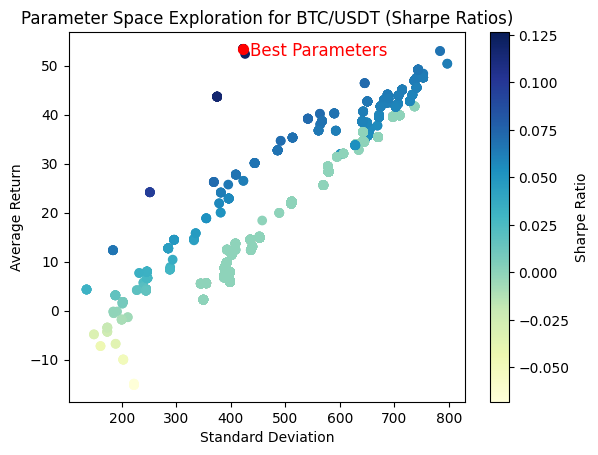

+----------+-------------------+-------+
|  Symbol  |  Best Parameters  | Value |
+----------+-------------------+-------+
| BTC/USDT |       gamma       |   2   |
| BTC/USDT |       sigma       |   8   |
| BTC/USDT |    T (minutes)    |  5.0  |
| BTC/USDT |         k         |   5   |
| BTC/USDT |         M         |  0.5  |
|          | Best Sharpe Ratio | 0.126 |
+----------+-------------------+-------+


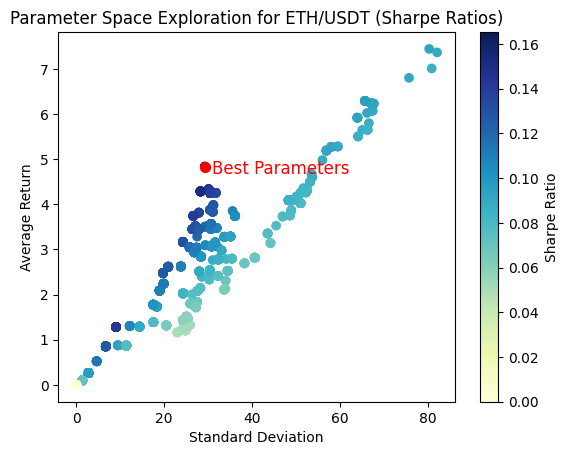

+----------+-------------------+-------+
|  Symbol  |  Best Parameters  | Value |
+----------+-------------------+-------+
| ETH/USDT |       gamma       |  0.8  |
| ETH/USDT |       sigma       |   7   |
| ETH/USDT |    T (minutes)    |  1.0  |
| ETH/USDT |         k         |   6   |
| ETH/USDT |         M         |  0.6  |
|          | Best Sharpe Ratio | 0.165 |
+----------+-------------------+-------+


In [ ]:
import numpy as np
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
from prettytable import PrettyTable

# Exchange and symbols
exchange = ccxt.binance()
symbols = ["BTC/USDT", "ETH/USDT"]

# Define proxy settings
proxy_host = '91.245.88.174'
proxy_port = '50100'
username = 'ktamimpro'
password = 'bUv2nWZsDt'

# Define proxy URL with authentication
proxy_url = f"http://{username}:{password}@{proxy_host}:{proxy_port}/"

# Initialize Binance exchange
exchange = ccxt.binance({
    'apiKey': 'k5TQskeKbtfvD8cf03x7YTLV4aIZoGP5i4CNTSZu1v32N9LhwNcTooxA6P5gNlFi',
    'secret': '4UmZl190bWQHBv3ytPTRewg1Qfl7ce3RiokCCmwpm1aqHqg9TBqBjzQLBN0aXgz6',
})
exchange.httpsProxy = proxy_url

# Avellaneda-Stoikov model logic
def avellaneda_stoikov(mid_price, gamma, sigma, T, k, M):
    sqrt_term = gamma * sigma * sigma * T
    fee = 0 #  Transaction Fee
    bid_quote = mid_price - k * sqrt_term - (mid_price * fee)
    ask_quote = mid_price + k * sqrt_term + (mid_price * fee)
    return bid_quote, ask_quote

best_parameters_symbol = {}

# Fetch historical data and calculate Sharpe ratio for each symbol
for symbol in symbols:
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe='5m', limit=200)  # Fetch 200 periods of 5-minutes data
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)

    # Calculate mid price using open and close prices
    df['mid_price'] = (df['open'] + df['close']) / 2

    # Calculate signals
    gamma_values = [0.5, 0.6, 0.7, 0.8, 0.9, 2]  # Values for gamma parameter
    sigma_values = [4, 5, 6, 7, 8, 9]  # Values for sigma parameter
    T_values = [1/60, 3/60, 5/60]  # Timeframe values in hours (1 minute, 3 minutes, 5 minutes)
    k_values = [2, 3, 4, 5, 6]  # Values for k parameter
    M_values = [0.3, 0.4, 0.5, 0.6, 0.7]  # Values for M parameter

    best_sharpe_ratio = -np.inf
    best_parameters = {}
    std_devs = []
    average_returns = []
    sharpe_ratios = []

    for gamma in gamma_values:
        for sigma in sigma_values:
            for T in T_values:
                for k in k_values:
                    for M in M_values:
                        df_temp = df.copy()
                        df_temp[['bid_quote', 'ask_quote']] = df_temp['mid_price'].apply(lambda x: avellaneda_stoikov(x, gamma, sigma, T, k, M)).apply(pd.Series)
                        df_temp['long_condition'] = df_temp['close'] < df_temp['bid_quote'] - M
                        df_temp['short_condition'] = df_temp['close'] > df_temp['ask_quote'] + M
                        df_temp['inventory'] = 0
                        df_temp.loc[df_temp['long_condition'], 'inventory'] += 1
                        df_temp.loc[df_temp['short_condition'], 'inventory'] -= 1
                        df_temp['inventory'] = df_temp['inventory'].cumsum()
                        df_temp['inventory_usd'] = df_temp['inventory'] * df_temp['close'].iloc[-1]
                        df_temp['pnl'] = 0
                        df_temp['pnl'] = np.where((df_temp['long_condition'] | df_temp['short_condition']), -df_temp['inventory'].shift() * (df_temp['close'] - df_temp['close'].shift()), 0)
                        df_temp['cumulative_pnl'] = df_temp['pnl'].cumsum()

                        # Calculate Sharpe ratio
                        returns = df_temp['pnl']
                        average_return = returns.mean()
                        std_dev = returns.std()
                        if std_dev != 0 and not returns.isnull().values.any():
                            sharpe_ratio = average_return / std_dev
                        else:
                            sharpe_ratio = 0

                        # Update best parameters if Sharpe ratio improves
                        if sharpe_ratio > best_sharpe_ratio:
                            best_sharpe_ratio = sharpe_ratio
                            best_parameters = {'symbol': symbol, 'gamma': gamma, 'sigma': sigma, 'T': T, 'k': k, 'M': M}

                        std_devs.append(std_dev)
                        average_returns.append(average_return)
                        sharpe_ratios.append(sharpe_ratio)

    # Plot average returns vs. standard deviations with colormap representing Sharpe ratios
    plt.scatter(std_devs, average_returns, c=sharpe_ratios, cmap='YlGnBu')
    plt.xlabel("Standard Deviation")
    plt.ylabel("Average Return")
    plt.title(f"Parameter Space Exploration for {symbol} (Sharpe Ratios)")
    plt.colorbar(label='Sharpe Ratio')

    # Mark the best parameter combination with a red circle
    best_index = sharpe_ratios.index(best_sharpe_ratio)
    best_std_dev = std_devs[best_index]
    best_average_return = average_returns[best_index]
    plt.scatter(best_std_dev, best_average_return, color='red', s=50)
    plt.annotate("Best Parameters", (best_std_dev, best_average_return), xytext=(5, -5),
                 textcoords='offset points', fontsize=12, color='red')

    plt.show()

    # Initialize an empty PrettyTable object with column names and Add the best parameters to the table
    results_table = PrettyTable()
    results_table.field_names = ["Symbol", "Best Parameters", "Value"]
    results_table.add_row([symbol, "gamma", round(best_parameters['gamma'], 3)])
    results_table.add_row([symbol, "sigma", round(best_parameters['sigma'], 3)])
    results_table.add_row([symbol, "T (minutes)", round(best_parameters['T'] * 60, 0)])
    results_table.add_row([symbol, "k", round(best_parameters['k'], 3)])
    results_table.add_row([symbol, "M", round(best_parameters['M'], 3)])
    results_table.add_row(["", "Best Sharpe Ratio", round(best_sharpe_ratio, 3)])
    best_parameters_symbol[symbol]=best_parameters

    # Display the results table
    print(results_table)

### 3.2 Backtesting and Performance

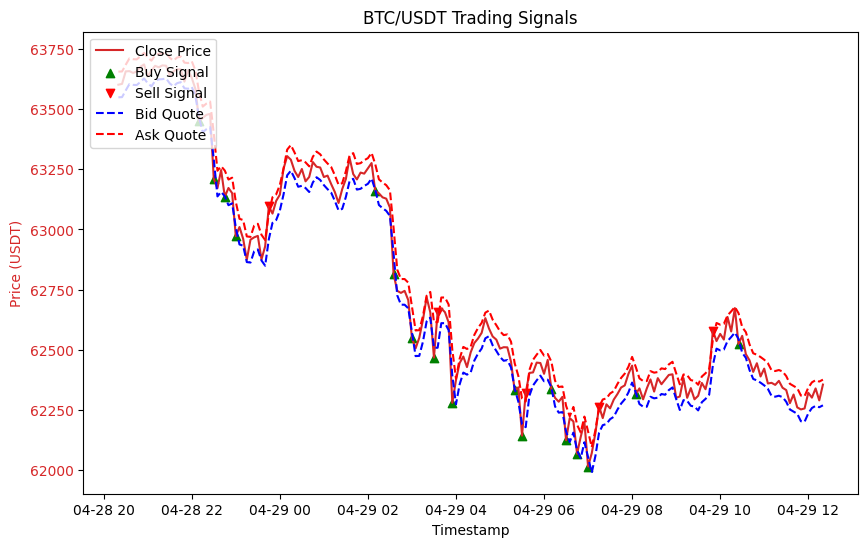

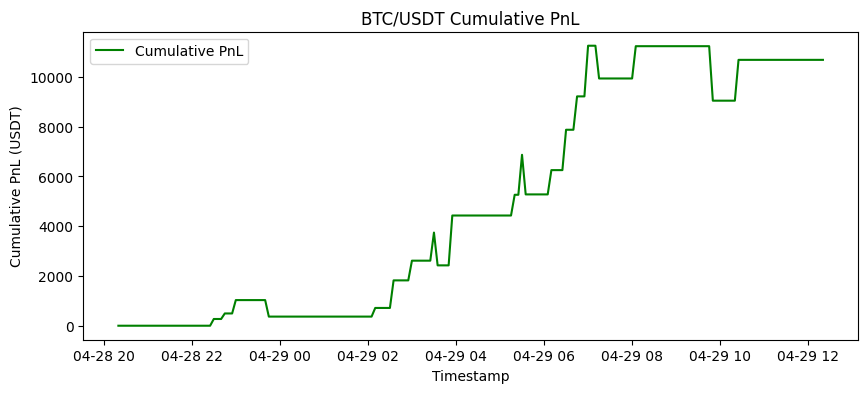

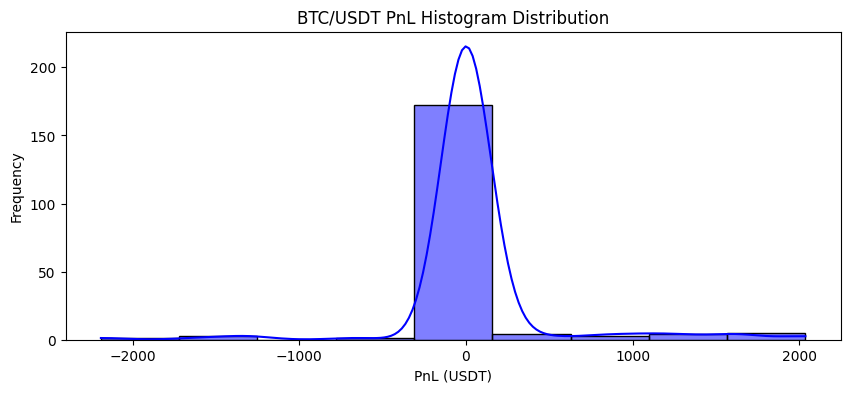

In [ ]:
import numpy as np
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import seaborn as sns

# Exchange and symbols (replace with your choice)
exchange = ccxt.binance()
symbols = ["BTC/USDT", "ETH/USDT"]

# Define your proxy settings
proxy_host = '91.245.88.174'
proxy_port = '50100'
username = 'ktamimpro'
password = 'bUv2nWZsDt'

# Define the proxy URL with authentication
proxy_url = f"http://{username}:{password}@{proxy_host}:{proxy_port}/"

# Initialize the Binance exchange
exchange = ccxt.binance({
    'apiKey': 'k5TQskeKbtfvD8cf03x7YTLV4aIZoGP5i4CNTSZu1v32N9LhwNcTooxA6P5gNlFi',
    'secret': '4UmZl190bWQHBv3ytPTRewg1Qfl7ce3RiokCCmwpm1aqHqg9TBqBjzQLBN0aXgz6',
})
exchange.httpsProxy = proxy_url

# Avellaneda-Stoikov model logic
def avellaneda_stoikov(mid_price, gamma, sigma, T, k, M):
    sqrt_term = gamma * sigma * sigma * T
    fee = 0 # 0.0% fee
    bid_quote = mid_price - k * sqrt_term - (mid_price * fee)
    ask_quote = mid_price + k * sqrt_term + (mid_price * fee)
    return bid_quote, ask_quote

# Fetch historical data
symbol = "BTC/USDT"
ohlcv = exchange.fetch_ohlcv(symbol, timeframe='5m', limit=200)  # Fetch 200 periods of 1-minute data
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Filter data for one hour
df = df[df.index >= df.index[-1] - pd.Timedelta(hours=16)]

# Calculate mid price using open and close prices
df['mid_price'] = (df['open'] + df['close']) / 2


# Define strategy parameters from previous calculated sharpe ratios
gamma = best_parameters_symbol[symbol]['gamma']
sigma = best_parameters_symbol[symbol]['sigma']
T = best_parameters_symbol[symbol]['T']
k = best_parameters_symbol[symbol]['k']
M = best_parameters_symbol[symbol]['M']

# Calculate signals
df[['bid_quote', 'ask_quote']] = df['mid_price'].apply(lambda x: avellaneda_stoikov(x, gamma, sigma, T, k, M)).apply(pd.Series)
df['long_condition'] = df['close'] < df['bid_quote'] - M
df['short_condition'] = df['close'] > df['ask_quote'] + M

# Calculate inventory level
df['inventory'] = 0
df.loc[df['long_condition'], 'inventory'] += 1
df.loc[df['short_condition'], 'inventory'] -= 1
df['inventory'] = df['inventory'].cumsum()

# Calculate value of inventory in USD
current_price = df.iloc[-1]['close']
df['inventory_usd'] = df['inventory'] * current_price

# Calculate PnL
df['pnl'] = 0
df['pnl'] = np.where((df['long_condition'] | df['short_condition']), -df['inventory'].shift() * (df['close'] - df['close'].shift()), 0)
df['cumulative_pnl'] = df['pnl'].cumsum()

# Plot signals
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:red'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Price (USDT)', color=color)
ax1.plot(df.index, df['close'], label='Close Price', color=color)
ax1.scatter(df.index[df['long_condition']], df['close'][df['long_condition']], color='green', marker='^', label='Buy Signal')
ax1.scatter(df.index[df['short_condition']], df['close'][df['short_condition']], color='red', marker='v', label='Sell Signal')
ax1.plot(df.index, df['bid_quote'], color='blue', linestyle='--', label='Bid Quote')
ax1.plot(df.index, df['ask_quote'], color='red', linestyle='--', label='Ask Quote')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_title('BTC/USDT Trading Signals')

# Plot cumulative PnL
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index, df['cumulative_pnl'], color='green', label='Cumulative PnL')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Cumulative PnL (USDT)')
ax.legend(loc='upper left')
ax.set_title('BTC/USDT Cumulative PnL')

# Plot PnL histogram distribution
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(df['pnl'], kde=True, color='blue', ax=ax)
ax.set_xlabel('PnL (USDT)')
ax.set_ylabel('Frequency')
ax.set_title('BTC/USDT PnL Histogram Distribution')

plt.show()


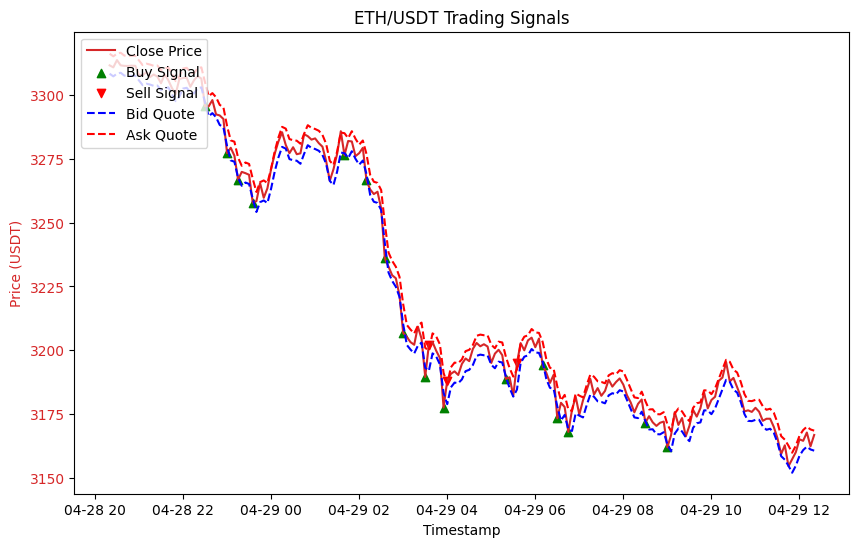

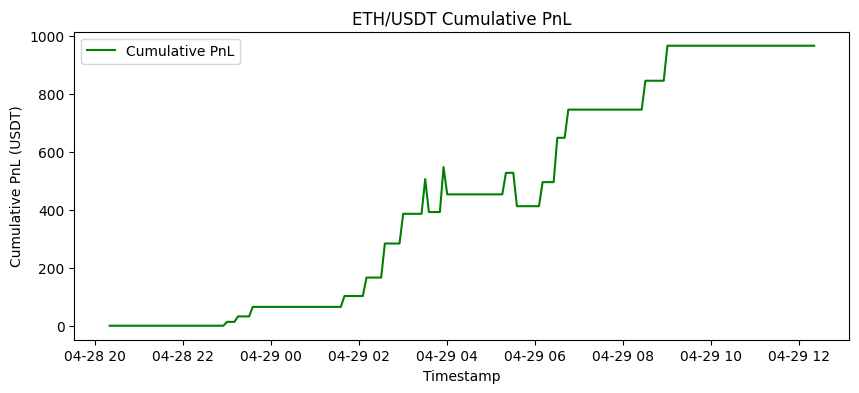

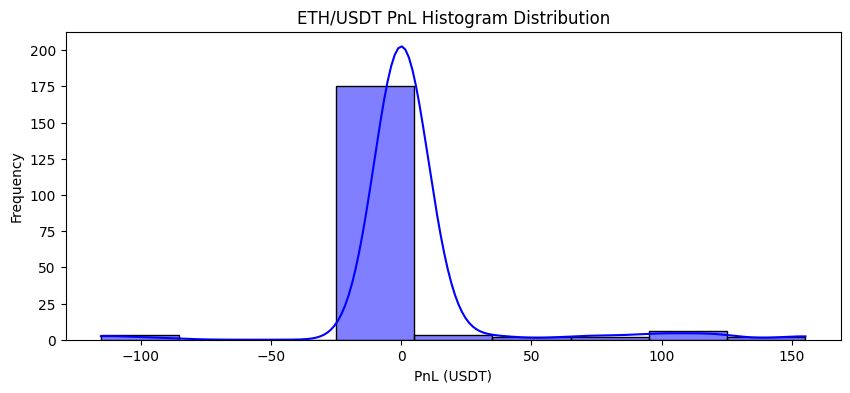

In [ ]:
import numpy as np
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import seaborn as sns

# Exchange and symbols (replace with your choice)
exchange = ccxt.binance()
symbols = ["BTC/USDT", "ETH/USDT"]

# Define your proxy settings
proxy_host = '91.245.88.174'
proxy_port = '50100'
username = 'ktamimpro'
password = 'bUv2nWZsDt'

# Define the proxy URL with authentication
proxy_url = f"http://{username}:{password}@{proxy_host}:{proxy_port}/"

# Initialize the Binance exchange
exchange = ccxt.binance({
    'apiKey': 'k5TQskeKbtfvD8cf03x7YTLV4aIZoGP5i4CNTSZu1v32N9LhwNcTooxA6P5gNlFi',
    'secret': '4UmZl190bWQHBv3ytPTRewg1Qfl7ce3RiokCCmwpm1aqHqg9TBqBjzQLBN0aXgz6',
})
exchange.httpsProxy = proxy_url

# Avellaneda-Stoikov model logic
def avellaneda_stoikov(mid_price, gamma, sigma, T, k, M):
    sqrt_term = gamma * sigma * sigma * T
    fee = 0  # 0.0% fee
    bid_quote = mid_price - k * sqrt_term - (mid_price * fee)
    ask_quote = mid_price + k * sqrt_term + (mid_price * fee)
    return bid_quote, ask_quote

# Fetch historical data
symbol = "ETH/USDT"
ohlcv = exchange.fetch_ohlcv(symbol, timeframe='5m', limit=200)  # Fetch 100 periods of 5-minute data
df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Filter data for one hour
df = df[df.index >= df.index[-1] - pd.Timedelta(hours=16)]

# Calculate mid price using open and close prices
df.loc[:, 'mid_price'] = (df['open'] + df['close']) / 2

# Define strategy parameters from previous calculated sharpe ratios
gamma = best_parameters_symbol[symbol]['gamma']
sigma = best_parameters_symbol[symbol]['sigma']
T = best_parameters_symbol[symbol]['T']
k = best_parameters_symbol[symbol]['k']
M = best_parameters_symbol[symbol]['M']

# Calculate signals
df[['bid_quote', 'ask_quote']] = df['mid_price'].apply(lambda x: avellaneda_stoikov(x, gamma, sigma, T, k, M)).apply(pd.Series)
df['long_condition'] = df['close'] < df['bid_quote'] - M
df['short_condition'] = df['close'] > df['ask_quote'] + M

# Calculate inventory level
df['inventory'] = 0
df.loc[df['long_condition'], 'inventory'] += 1
df.loc[df['short_condition'], 'inventory'] -= 1
df['inventory'] = df['inventory'].cumsum()

# Calculate value of inventory in USD
current_price = df.iloc[-1]['close']
df['inventory_usd'] = df['inventory'] * current_price

# Calculate PnL
df['pnl'] = 0
df['pnl'] = np.where((df['long_condition'] | df['short_condition']), -df['inventory'].shift() * (df['close'] - df['close'].shift()), 0)
df['cumulative_pnl'] = df['pnl'].cumsum()

# Plot signals
fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:red'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Price (USDT)', color=color)
ax1.plot(df.index, df['close'], label='Close Price', color=color)
ax1.scatter(df.index[df['long_condition']], df['close'][df['long_condition']], color='green', marker='^', label='Buy Signal')
ax1.scatter(df.index[df['short_condition']], df['close'][df['short_condition']], color='red', marker='v', label='Sell Signal')
ax1.plot(df.index, df['bid_quote'], color='blue', linestyle='--', label='Bid Quote')
ax1.plot(df.index, df['ask_quote'], color='red', linestyle='--', label='Ask Quote')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.set_title('ETH/USDT Trading Signals')

# Plot cumulative PnL
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.index, df['cumulative_pnl'], color='green', label='Cumulative PnL')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Cumulative PnL (USDT)')
ax.legend(loc='upper left')
ax.set_title('ETH/USDT Cumulative PnL')

# Plot PnL histogram distribution
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(df['pnl'], kde=True, color='blue', ax=ax)
ax.set_xlabel('PnL (USDT)')
ax.set_ylabel('Frequency')
ax.set_title('ETH/USDT PnL Histogram Distribution')

plt.show()
